# Nubalu -- Data Science project
by Héctor Ramírez

<hr>

In this notebook, we construct a predictive model regarding the Spanish Property Price Index (PPI) based on a set of features such as <i>unemployment rate</i> or <i>construction workers</i>. As <a href='https://en.wikipedia.org/wiki/House_price_index'> Wikipedia</a> states: "A house price index (HPI) measures the price changes of residential housing as a percentage change from some specific start date (which has HPI of 100)".

<hr>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
import warnings
warnings.filterwarnings('ignore')

<hr>
Here, we start from an already engineered dataset whose source data come from the <a href='https://www.ine.es/dyngs/INEbase/listaoperaciones.htm'><i>Instituto Nacional de Estadística</i> (INE)</a>. The data set contains 50 non-null entries and 6 features.
<hr>

In [2]:
data = pd.read_csv('dataset.csv')
# data.property_price_index.plot.line()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
property_transactions    50 non-null float64
mortgages_amount         50 non-null float64
consumer_price_index     50 non-null float64
gross_income             50 non-null float64
unemployment_rate        50 non-null float64
construction_workers     50 non-null float64
property_price_index     50 non-null float64
dtypes: float64(7)
memory usage: 2.8 KB
None


<hr>

To start the construction of the predictive model, we assign the features to a set <code>X</code> and keep the target as a <code>y</code> array. Then we split the data into training and test sets using the <code>train_test_split</code> module from <code>sklearn.model_selection</code>. We choose to keep 30% of the data set as test set.

<hr>

In [3]:
data = pd.read_csv('dataset.csv')
# data.property_price_index.plot.line()

X = data.drop(['property_price_index'], axis=1)  # Features
y = data['property_price_index']  # Target

seed = 123

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

## Linear Regressor

First, we try a simple linear regressor using <code>LinearRegression()</code> from <code>sklearn.linear_model</code>. As test metrics, we will apply the <b>root mean squared error</b> and the <b>coefficient of determination</b> $R^2$ (score).

In [4]:
lr = LinearRegression()  # we initialize the regressor

lr.fit(X_train, y_train)  # fit
y_pred_lr = lr.predict(X_test)  # predict

lr_error = mse(y_test, y_pred_lr)**(1/2)
lr_accuracy = r2_score(y_test, y_pred_lr)

print('Test set RMSE of linear regressor: {:.2f}'.format(lr_error))
print('Test set score of linear regressor: {:.4f}'.format(lr_accuracy))

Test set RMSE of linear regressor: 4.35
Test set score of linear regressor: 0.9414


<hr>
The simple Linear Regressor performs fairly well, with a score of 94% when applied on the test set.
<hr>

## Random Forest

However, let's try a slightly more complex regressor using Random Forests. Here, instead of simply suggesting a model, we perform a parameter grid search using <code>GridSearchCV</code> from <code>sklearn.model_selection</code> by varying the number of stimators, the maximum tree depth and the minimum of leaf samples, this while cross-validating the model.

In [5]:
rf_g = RandomForestRegressor(random_state=seed)  # initialize regressor

params_rf = {'n_estimators': [600, 700, 800], 'max_depth': [3, 4, 5], 'min_samples_leaf': np.arange(0.1, 0.2, 0.02)}  # params to vary

grid_rf = GridSearchCV(estimator=rf_g, param_grid=params_rf, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)  # start grid

grid_rf.fit(X_train, y_train)  # fit

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
          

<hr>
After we fit the grid, we extract the best hyperparameters and the best estimator, which we define as <code>best_model</code>. And compute the same metrics as before.
<hr>

In [6]:
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_model = grid_rf.best_estimator_
y_pred_grid = best_model.predict(X_test)  # predict

grid_rf_error = mse(y_test, y_pred_grid)**(1/2)
grid_rf_accuracy = r2_score(y_test, y_pred_grid)

print('\n')
print('Test set RMSE of complex random forest: {:.2f}'.format(grid_rf_error))
print('Test set score of complex random forest: {:.4f}'.format(grid_rf_accuracy))

Best hyperparameters:
 {'max_depth': 4, 'min_samples_leaf': 0.1, 'n_estimators': 600}


Test set RMSE of complex random forest: 2.83
Test set score of complex random forest: 0.9751


<hr>
As we can see, our RandomForest regressor outperforms the simple linear regresor, with an score of 97% when applied on the test set.
<br>
Finally, we can take the most important features employed by the RandomForest regressor and show them in a bar plot. We notice that <i>construction_workers</i> is by far the most important feature, followed by <i>mortages amount</i> and the <i>consumer_price_index</i>.
<hr>

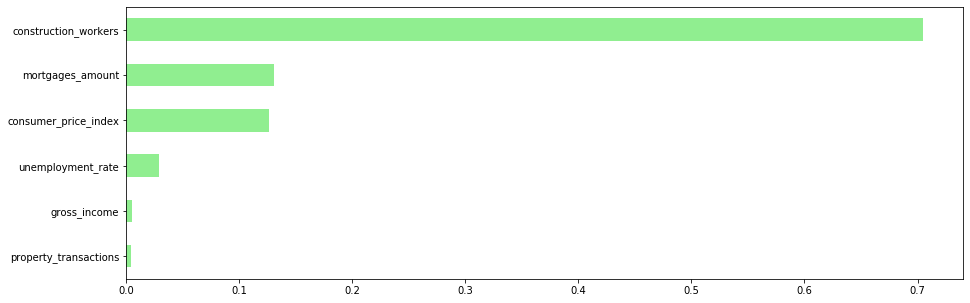

In [7]:
importances_rf = pd.Series(best_model.feature_importances_, index=X.columns)  # get the most importan features
sorted_importances_rf = importances_rf.sort_values()

plt.figure(figsize=(15, 5))
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

<hr>
As a final comment, from our bar plot, we can see that there are two features that barely contribute to the RandomForest regressor: <i>gross_income</i> and <i>property_transactions</i>. We could drop them from the training set and build again the regressor. The prediction would slightly improve, giving an $R^2$ of 0.9753.
<hr>